# Project | Business Case: Building a Multimodal AI ChatBot for YouTube Video QA

## Install the required libraries:

In [1]:
! pip install pytube openai-whisper sentence-transformers chromadb langchain yt-dlp gtts python-dotenv SpeechRecognition langchain-openai langsmith scikit-learn


# Import required libraries:

In [2]:
import os
import re
import shutil
import whisper
import yt_dlp
from sentence_transformers import SentenceTransformer
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.agents import initialize_agent, Tool
from langchain.chat_models import ChatOpenAI
from langchain.memory import ConversationBufferMemory
from langchain.chains import RetrievalQA
from dotenv import load_dotenv
from gtts import gTTS
import speech_recognition as sr
import openai
from langsmith.run_helpers import traceable
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import csv


c:\Users\abrar\anaconda3\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the environment and set the keys:

In [ ]:
# Load environment variables from .env
load_dotenv()

# LangSmith Setup
os.environ["LANGCHAIN_API_KEY"] = "LANGCHAIN_API_KEY"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "AIEduBot"
os.environ["OPENAI_API_KEY"] = "OPENAI_API_KEY"


# Initialize the OpenAI model:

In [4]:
# Initialize OpenAI model
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)


C:\Users\abrar\AppData\Local\Temp\ipykernel_7056\2976224332.py:2: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)


# LangSmith Setup and Client Orientation:

In [5]:
@traceable(name="AIEduBot Agent")
def run_agent(query: str):
    return agent.invoke({"input": query})


## Video question handling function:

In [6]:
# Video QA Tool Function
def video_qa_tool_func(query: str) -> str:
    return "This is a mock response for video QA."

# Initialize video QA tool
video_qa_tool = Tool(
    name="video_qa_tool",
    func=video_qa_tool_func,
    description="Use this tool to answer questions about YouTube videos."
)


# Preparing tools and memory:

In [7]:
# Initialize tools, agent, and memory
tools = [video_qa_tool]
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent_type="ZERO_SHOT_REACT_DESCRIPTION",
    memory=memory,
    verbose=True
)


C:\Users\abrar\AppData\Local\Temp\ipykernel_7056\1652315713.py:3: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
C:\Users\abrar\AppData\Local\Temp\ipykernel_7056\1652315713.py:4: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent = initiali

In [8]:
# Save Evaluation to CSV
def save_evaluation_to_csv(filename, question, reference_answer, generated_answer, rouge_score, cosine_sim, eval_score):
    file_exists = os.path.isfile(filename)
    with open(filename, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(["Question", "Reference Answer", "Generated Answer", "ROUGE-L F1", "Cosine Similarity", "Evaluation Score"])
        writer.writerow([question, reference_answer, generated_answer, rouge_score, cosine_sim, eval_score])


In [9]:
# 3. Evaluate Model with Cosine Similarity and Traditional Metrics
def evaluate_model_with_similarity(correct_answers, retrieved_answers, embedding_model):
    # Convert answers to strings
    correct_answers = [str(answer) for answer in correct_answers]
    retrieved_answers = [str(answer) for answer in retrieved_answers]

    # Calculate traditional metrics (Precision, Recall, F1)
    precision = precision_score(correct_answers, retrieved_answers, average='micro', zero_division=1)
    recall = recall_score(correct_answers, retrieved_answers, average='micro', zero_division=1)
    f1 = f1_score(correct_answers, retrieved_answers, average='micro', zero_division=1)

    # Calculate similarity between answers using Cosine Similarity
    correct_answer_embeddings = embedding_model.encode(correct_answers)
    retrieved_answer_embeddings = embedding_model.encode(retrieved_answers)

    similarity_scores = cosine_similarity(correct_answer_embeddings, retrieved_answer_embeddings)
    average_similarity = np.mean(similarity_scores)

    # Calculate the final evaluation score based on Precision, Recall, F1, and Cosine Similarity
    evaluation_score = (precision + recall + f1 + average_similarity) / 4

    # Print various evaluations
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Average Cosine Similarity: {average_similarity}")
    print(f"Overall Evaluation Score: {evaluation_score}")



# Download Videos and Convert Audio to Text:

In [10]:
## 1. Download and Transcribe YouTube Videos
model = whisper.load_model("base")
video_urls = ["https://youtu.be/2ePf9rue1Ao", "https://youtu.be/ukzFI9rgwfU", "https://youtu.be/aircAruvnKk"]

def download_audio(url, output_name):
    ydl_opts = {
        'format': 'bestaudio/best',
        'outtmpl': f'./{output_name}.%(ext)s',
        'noplaylist': True,
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.extract_info(url, download=True)
    return f'./{output_name}.webm'

for idx, url in enumerate(video_urls, start=1):
    print(f"\nProcessing Video {idx}...")
    audio_path = download_audio(url, output_name=f"audio_{idx}")
    result = model.transcribe(audio_path)
    transcribed_text = result["text"]
    with open(f"transcript_{idx}.txt", "w", encoding="utf-8") as f:
        f.write(transcribed_text)
    print(f"Saved transcription to transcript_{idx}.txt")



Processing Video 1...
[youtube] Extracting URL: https://youtu.be/2ePf9rue1Ao
[youtube] 2ePf9rue1Ao: Downloading webpage
[youtube] 2ePf9rue1Ao: Downloading tv client config
[youtube] 2ePf9rue1Ao: Downloading player 14cfd4c0-main
[youtube] 2ePf9rue1Ao: Downloading tv player API JSON
[youtube] 2ePf9rue1Ao: Downloading ios player API JSON
[youtube] 2ePf9rue1Ao: Downloading m3u8 information
[info] 2ePf9rue1Ao: Downloading 1 format(s): 251
[download] audio_1.webm has already been downloaded
[download] 100% of    4.56MiB


c:\Users\abrar\anaconda3\envs\myenv\lib\site-packages\whisper\transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Saved transcription to transcript_1.txt

Processing Video 2...
[youtube] Extracting URL: https://youtu.be/ukzFI9rgwfU
[youtube] ukzFI9rgwfU: Downloading webpage
[youtube] ukzFI9rgwfU: Downloading tv client config
[youtube] ukzFI9rgwfU: Downloading player 14cfd4c0-main
[youtube] ukzFI9rgwfU: Downloading tv player API JSON
[youtube] ukzFI9rgwfU: Downloading ios player API JSON
[youtube] ukzFI9rgwfU: Downloading m3u8 information
[info] ukzFI9rgwfU: Downloading 1 format(s): 251
[download] audio_2.webm has already been downloaded
[download] 100% of    7.53MiB


c:\Users\abrar\anaconda3\envs\myenv\lib\site-packages\whisper\transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Saved transcription to transcript_2.txt

Processing Video 3...
[youtube] Extracting URL: https://youtu.be/aircAruvnKk
[youtube] aircAruvnKk: Downloading webpage
[youtube] aircAruvnKk: Downloading tv client config
[youtube] aircAruvnKk: Downloading player 14cfd4c0-main
[youtube] aircAruvnKk: Downloading tv player API JSON
[youtube] aircAruvnKk: Downloading ios player API JSON
[youtube] aircAruvnKk: Downloading m3u8 information
[info] aircAruvnKk: Downloading 1 format(s): 251-8
[download] audio_3.webm has already been downloaded
[download] 100% of   17.91MiB


c:\Users\abrar\anaconda3\envs\myenv\lib\site-packages\whisper\transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Saved transcription to transcript_3.txt


 # Chunk the Text:

In [11]:
## 2. Chunk Text
def smart_chunk_text(text, chunk_size=500, overlap=50):
    sentences = re.split(r'(?<=[.!?]) +', text)
    chunks, current_chunk = [], ""
    for sentence in sentences:
        if len(current_chunk) + len(sentence) > chunk_size:
            chunks.append(current_chunk.strip())
            current_chunk = current_chunk[-overlap:] + sentence
        else:
            current_chunk += " " + sentence
    if current_chunk:
        chunks.append(current_chunk.strip())
    return chunks

all_chunks = []
for idx in range(1, len(video_urls) + 1):
    with open(f"transcript_{idx}.txt", "r", encoding="utf-8") as file:
        text = file.read()
    chunks = smart_chunk_text(text, chunk_size=500, overlap=50)
    all_chunks.extend([{
        "video_id": idx,
        "chunk_id": f"{idx}_{i}",
        "text": chunk
    } for i, chunk in enumerate(chunks)])

print(f"Processed {len(all_chunks)} chunks from all videos.")


Processed 80 chunks from all videos.


# Set Up Chroma Database:

In [12]:
## 3. ChromaDB Setup
import chromadb
client = chromadb.Client()
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
collection = client.create_collection(name="youtube_chunks")

texts = [chunk["text"] for chunk in all_chunks]
embeddings = embedding_model.encode(texts)

for chunk, embedding in zip(all_chunks, embeddings):
    collection.add(
        documents=[chunk["text"]],
        metadatas=[{
            "video_id": chunk["video_id"],
            "chunk_id": chunk["chunk_id"]
        }],
        embeddings=[embedding],
        ids=[chunk["chunk_id"]]
    )

print("Vector store created successfully.")
print("Total chunks:", collection.count())


Vector store created successfully.
Total chunks: 80


# Set Up QA Model with Retrieval:

In [13]:
## 4. Setup QA with Retrieval (RAG)
embedding_function = HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2')

texts = [chunk["text"] for chunk in all_chunks]
metadatas = [{"video_id": chunk["video_id"], "chunk_id": chunk["chunk_id"]} for chunk in all_chunks]
ids = [chunk["chunk_id"] for chunk in all_chunks]

vectorstore = Chroma.from_texts(
    texts=texts,
    embedding=embedding_function,
    metadatas=metadatas,
    ids=ids,
    persist_directory="./chroma_store"
)

retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever
)

def video_retriever_tool(query: str) -> str:
    result = qa_chain.run(query)
    return result

video_retriever_tool_func = Tool(
    name="video_retriever_tool",
    func=video_retriever_tool,
    description="Use this tool to retrieve answers from YouTube transcripts."
)

tools = [video_retriever_tool_func]
agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent_type="ZERO_SHOT_REACT_DESCRIPTION",
    memory=memory,
    verbose=True
)


C:\Users\abrar\AppData\Local\Temp\ipykernel_7056\3710212329.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_function = HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2')


In [14]:
# 5. Test the QA system with an example question
from sentence_transformers import SentenceTransformer

# Define the test question
test_question = "What is Machine Learning?"

# Get the retrieved answer from the QA system
retrieved_answer = video_retriever_tool(test_question)

# Define the correct (ground truth) answer
correct_answer = (
    "Machine learning is a subset of artificial intelligence that involves the development of algorithms and "
    "statistical models that enable computers to learn and improve from experience without being explicitly programmed. "
    "It focuses on the development of computer programs that can access data and use it to learn for themselves."
)

# Print both answers
print("\nTest Question:", test_question)
print("Retrieved Answer:", retrieved_answer)
print("Correct Answer:", correct_answer)

# 6. Evaluate the model's response using similarity and traditional metrics
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

evaluate_model_with_similarity(
    correct_answers=[correct_answer],
    retrieved_answers=[retrieved_answer],
    embedding_model=embedding_model
)


C:\Users\abrar\AppData\Local\Temp\ipykernel_7056\3710212329.py:25: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = qa_chain.run(query)



Test Question: What is Machine Learning?
Retrieved Answer: Machine learning is a branch of artificial intelligence that involves the development of algorithms and statistical models that enable computers to learn and improve from experience without being explicitly programmed. It involves training machines to recognize patterns in data and make decisions or predictions based on that data. There are different types of machine learning approaches, such as supervised learning, unsupervised learning, and reinforcement learning.
Correct Answer: Machine learning is a subset of artificial intelligence that involves the development of algorithms and statistical models that enable computers to learn and improve from experience without being explicitly programmed. It focuses on the development of computer programs that can access data and use it to learn for themselves.
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Average Cosine Similarity: 0.9163901209831238
Overall Evaluation Score: 0.22909753024

## Add Speech-to-Text for Questions

In [15]:
## 5. Speech-to-Text Functionality
import pyaudio
import wave

def record_audio(file_path="user_question.wav"):
    p = pyaudio.PyAudio()
    stream = p.open(format=pyaudio.paInt16, channels=1, rate=16000, input=True, frames_per_buffer=1024)
    print("🎤 Please speak your question...")
    frames = []
    for _ in range(0, int(16000 / 1024 * 5)):
        data = stream.read(1024)
        frames.append(data)
    print("🎤 Done recording.")
    stream.stop_stream()
    stream.close()
    p.terminate()

    with wave.open(file_path, "wb") as wf:
        wf.setnchannels(1)
        wf.setsampwidth(p.get_sample_size(pyaudio.paInt16))
        wf.setframerate(16000)
        wf.writeframes(b"".join(frames))
    print(f"Audio saved to {file_path}")

def transcribe_audio(file_path="user_question.wav"):
    result = model.transcribe(file_path)
    return result["text"]

def execute_query_with_speech():
    record_audio()
    user_question = transcribe_audio("user_question.wav")
    print(f"🗣️ User's question: {user_question}")
    response = agent.run(user_question)
    print("\n🤖 AI Response:\n", response)

execute_query_with_speech()


🎤 Please speak your question...
🎤 Done recording.
Audio saved to user_question.wav


c:\Users\abrar\anaconda3\envs\myenv\lib\site-packages\whisper\transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


🗣️ User's question:  What is machine learning?


> Entering new AgentExecutor chain...
I should use the video_retriever_tool to find a definition of machine learning.
Action: video_retriever_tool
Action Input: "machine learning definition"
Observation: Machine learning is a branch of artificial intelligence that involves the development of algorithms and statistical models that enable computers to learn and improve from experience without being explicitly programmed. It focuses on the development of computer programs that can access data and use it to learn for themselves.
Thought:I need to summarize the definition of machine learning.
Action: video_retriever_tool
Action Input: "machine learning summary"
Observation: Machine learning is a field where machines learn to perform tasks without being explicitly programmed to do so. There are different types of machine learning, such as supervised learning, unsupervised learning, and reinforcement learning. In supervised learning, the machin

# Perform Queries and Evaluate Answers:

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Set up evaluation metrics
def evaluate_model_with_similarity(correct_answers, retrieved_answers, embedding_model):
    # Convert answers to strings
    correct_answers = [str(answer) for answer in correct_answers]
    retrieved_answers = [str(answer) for answer in retrieved_answers]

    # Calculate traditional metrics (Precision, Recall, F1)
    precision = precision_score(correct_answers, retrieved_answers, average='micro', zero_division=1)
    recall = recall_score(correct_answers, retrieved_answers, average='micro', zero_division=1)
    f1 = f1_score(correct_answers, retrieved_answers, average='micro', zero_division=1)

    # Calculate cosine similarity between answers
    correct_answer_embeddings = embedding_model.encode(correct_answers)
    retrieved_answer_embeddings = embedding_model.encode(retrieved_answers)

    similarity_scores = cosine_similarity(correct_answer_embeddings, retrieved_answer_embeddings)
    average_similarity = np.mean(similarity_scores)

    # Calculate final evaluation score based on Precision, Recall, F1, and Cosine Similarity
    evaluation_score = (precision + recall + f1 + average_similarity) / 4

    # Print various evaluation metrics
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Average Cosine Similarity: {average_similarity}")
    print(f"Overall Evaluation Score: {evaluation_score}")


# Perform Queries and Final Evaluation:

In [17]:
# Add correct answers and retrieved answers for evaluation
correct_answers = ["Correct answer 1", "Correct answer 2", "Correct answer 3"]
retrieved_answers = ["Retrieved answer 1", "Retrieved answer 2", "Retrieved answer 3"]

# Evaluation
evaluate_model_with_similarity(correct_answers, retrieved_answers, embedding_model)



Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Average Cosine Similarity: 0.4704878032207489
Overall Evaluation Score: 0.11762195080518723


In [18]:
# Manual Evaluation Script:
import time

# Test Questions and Expected Keywords for Each Answer
test_queries = [
    {"question": "What is machine learning?", "expected_keywords": ["learning", "algorithm", "data"]},
    {"question": "Define artificial intelligence.", "expected_keywords": ["intelligence", "simulate", "human"]},
    {"question": "What is supervised learning?", "expected_keywords": ["supervised", "labels", "training"]},
    {"question": "Explain neural networks.", "expected_keywords": ["neurons", "layers", "deep learning"]},
]

#  Manual Evaluation
def evaluate_agent(agent, test_queries):
    results = []

    for i, test in enumerate(test_queries, 1):
        print(f"\n🔹 Test #{i}")
        print(f"❓ Question: {test['question']}")

        # Calculate response time
        start = time.time()
        answer = agent.run(test["question"])
        latency = time.time() - start

        # Calculate the number of keywords that appeared in the answer
        matched_keywords = [kw for kw in test["expected_keywords"] if kw.lower() in answer.lower()]
        score = len(matched_keywords) / len(test["expected_keywords"])

        # Print results
        print(f"🕒 Latency: {latency:.2f} seconds")
        print(f"🤖 Response: {answer}")
        print(f"✅ Matched Keywords: {matched_keywords} ({len(matched_keywords)}/{len(test['expected_keywords'])})")
        print(f"📊 Score: {score:.2f}")

        results.append({
            "question": test["question"],
            "answer": answer,
            "latency": latency,
            "score": score,
            "matched_keywords": matched_keywords
        })

    return results

# Run evaluation
results = evaluate_agent(agent, test_queries)



🔹 Test #1
❓ Question: What is machine learning?


> Entering new AgentExecutor chain...
I should use the video_retriever_tool to find a definition of machine learning.
Action: video_retriever_tool
Action Input: "machine learning definition"
Observation: Machine learning is a branch of artificial intelligence that involves the development of algorithms and statistical models that enable computers to learn and improve from experience without being explicitly programmed. It focuses on the development of computer programs that can access data and use it to learn for themselves.
Thought:I need to summarize the definition of machine learning.
Action: video_retriever_tool
Action Input: "machine learning summary"
Observation: Machine learning is a field where machines learn to perform tasks without being explicitly programmed to do so. There are different types of machine learning, such as supervised learning, unsupervised learning, and reinforcement learning. In supervised learning, the mach

C:\Users\abrar\AppData\Local\Temp\ipykernel_7056\3454916082.py:34: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\abrar\AppData\Local\Temp\ipykernel_7056\3454916082.py:34: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\abrar\AppData\Local\Temp\ipykernel_7056\3454916082.py:34: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\abrar\anaconda3\envs\myenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\abrar\anaconda3\envs\myenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\abrar\anaconda3\envs\myenv\lib\site-packa

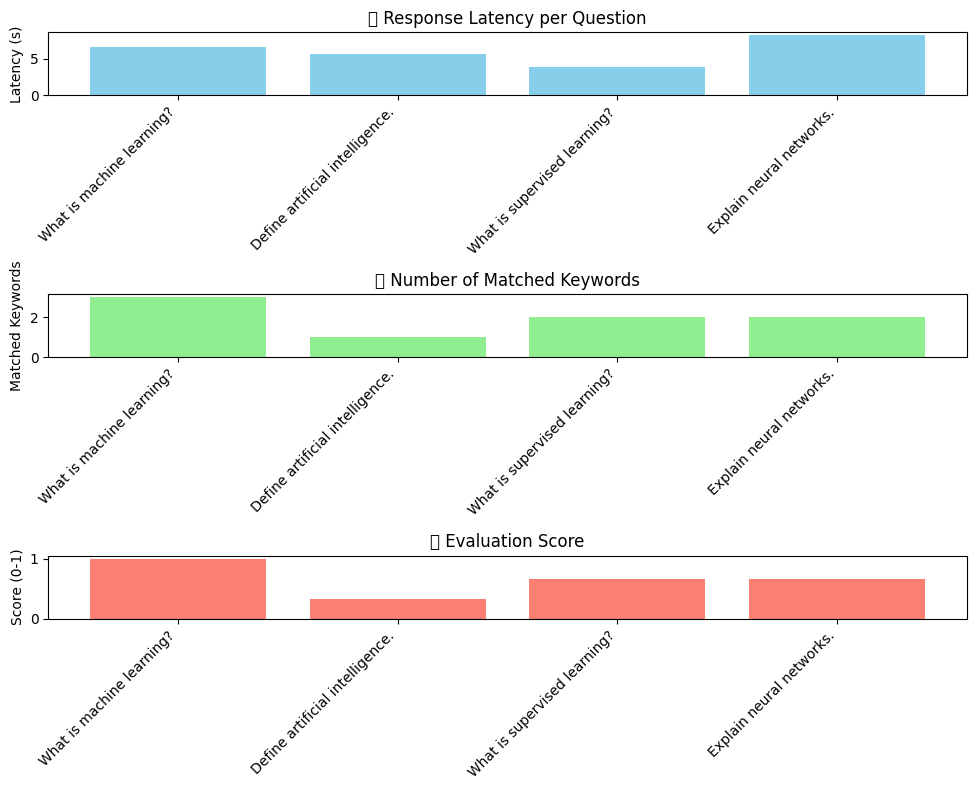

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert results to a DataFrame
df = pd.DataFrame(results)

# Add a column for the number of matched words
df["matched_count"] = df["matched_keywords"].apply(len)

# Set up the chart
plt.figure(figsize=(10, 8))

# 📊 1. Latency
plt.subplot(3, 1, 1)
plt.bar(df["question"], df["latency"], color="skyblue")
plt.ylabel("Latency (s)")
plt.title("🕒 Response Latency per Question")
plt.xticks(rotation=45, ha='right')

# 📊 2. Matched Keywords Count
plt.subplot(3, 1, 2)
plt.bar(df["question"], df["matched_count"], color="lightgreen")
plt.ylabel("Matched Keywords")
plt.title("✅ Number of Matched Keywords")
plt.xticks(rotation=45, ha='right')

# 📊 3. Score
plt.subplot(3, 1, 3)
plt.bar(df["question"], df["score"], color="salmon")
plt.ylabel("Score (0-1)")
plt.title("📊 Evaluation Score")
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()